# MS-E2121 - Linear Optimization: Homework 6
#' 
## Exercise 6.2 - Valid inequalities for the TSP
Solve item (b) here. In the following cells you are provided with the **same code** as presented in session 8 for solving the TSP-MTZ.

In [1]:
import Pkg; Pkg.add("Combinatorics") # Had to run this to get cell below working

    Updating registry at `/opt/julia/registries/General`
┌ Warning: could not download https://pkg.julialang.org/registries
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Types.jl:997
   Resolving package versions...
   Installed Combinatorics ─ v1.0.2
    Updating `/opt/julia/environments/v1.6/Project.toml`
  [861a8166] + Combinatorics v1.0.2
    Updating `/opt/julia/environments/v1.6/Manifest.toml`
  [861a8166] + Combinatorics v1.0.2
Precompiling project...
  ✓ Combinatorics
  1 dependency successfully precompiled in 2 seconds (213 already precompiled)


In [2]:
using JuMP                         # JuMP: Modeling language and solver interface
using DelimitedFiles               # IO reading/writting files
using Cbc                          # Solver
using LinearAlgebra                # To use the norm
using Plots                        # For plotting the tours
using Combinatorics                # To perform permutations

In [3]:
## Function for getting the distances array
function get_dist(xycoord::Matrix{},n::Int)
    # Compute distance matrix (d[i,j]) from city coordinates
    
    dist = zeros(n,n)
    for i = 1:n
        for j = i:n
            d = norm(xycoord[i,:] - xycoord[j,:])
            dist[i,j] = d
            dist[j,i] = d
        end
    end
    return dist
end

get_dist (generic function with 1 method)

In [4]:
# Get the optimal tour
# Input
#     x: solution matrix 
#     n: number of cities
# Returns
#     tour: ordering of cities in the optimal tour
function gettour(x::Matrix{Int}, n::Int)
    tour = zeros(Int,n+1)   # Initialize tour vector (n+1 as city 1 appears twice)
    tour[1] = 1             # Set city 1 as first one in the tour
    k = 2                   # Index of vector tour[k]
    i = 1                   # Index of current city 
    while k <= n + 1        # Find all n+1 tour nodes (city 1 is counted twice)
        for j = 1:n         
            if x[i,j] == 1  # Find next city j visited immediately after i
                tour[k] = j # Set city j as the k:th city in the tour
                k = k + 1   # Update index k of tour[] vector
                i = j       # Move to next city
                break       
            end
        end
    end 
    return tour             # Return the optimal tour 
end

gettour (generic function with 1 method)

In [5]:
# Solve a directed, TSP instance (MTZ formulation)
# Input
#    xycoord: coordinates of city locations
#    n: number of cities
# Returns
#    tour: ordering of cities in the optimal tour
#    cost: cost (length) of the optimal tour
function tsp_mtz(xycoord::Matrix{}, n::Int)
    
    # Create a model 
    m = Model(Cbc.Optimizer)  
    
    # Here the costs c are the distances between cities
    c = get_dist(xycoord,n)
    
    ## Variables

    # x[i,j] = 1 if we travel from city i to city j, 0 otherwise.
    @variable(m, x[1:n,1:n], Bin)
    # Variables u for subtour elimination constraints
    @variable(m, u[2:n])   
    
    ## Objective
    
    # Minimize length of tour
    @objective(m, Min, dot(c,x))

    ## Constraints
    
    # Ignore self arcs: set x[i,i] = 0  
    @constraint(m, sar[i = 1:n], x[i,i] == 0)

    # We must enter and leave every city exactly once             
    @constraint(m, ji[i = 1:n], sum(x[j,i] for j = 1:n if j != i) == 1)
    @constraint(m, ij[i = 1:n], sum(x[i,j] for j = 1:n if j != i) == 1)
                                    
    # MTZ subtour elimination constraints
    @constraint(m, sub[i = 2:n, j = 2:n, i != j], u[i] - u[j] + (n-1)*x[i,j] <= (n-2))
                                
    optimize!(m)
                                
    cost = objective_value(m)         # Optimal cost (length)
    sol_x = round.(Int, value.(x))    # Optimal solution vector
    
    tour = gettour(sol_x,n)           # Get the optimal tour
    
    return tour, cost
end;

In [6]:
## "data16c.csv" has 3 columns which are stored in arrays
## V, x and y. The columns contain:
##
##     data[:,1]: all cities i in V
##     data[:,2]: x-coordinate of each city i in V
##     data[:,3]: y-coordinate of each city i in V

data  = readdlm("data16c.csv", ';')   
n = 16                  # number of cities 
# println(data)         # Look at the data in compact form
V = data[2:n+1,1]       # All cities i in V
x = data[2:n+1,2]       # x-coordinates of cities i in V
y = data[2:n+1,3]       # y-coordinates of cities i in V
xycoord = [x y];        # n x 2 coordinate matrix

In [7]:
@time (tour, cost) = tsp_mtz(xycoord, n);

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 12110.7 - 0.00 seconds
Cgl0002I 16 variables fixed
Cgl0004I processed model has 242 rows, 255 columns (240 integer (240 of which binary)) and 1110 elements
Cbc0038I Initial state - 27 integers unsatisfied sum - 2.13333
Cbc0038I Pass   1: suminf.    1.86667 (19) obj. 13308.1 iterations 41
Cbc0038I Pass   2: suminf.    2.13333 (9) obj. 22458.2 iterations 56
Cbc0038I Pass   3: suminf.    1.86667 (13) obj. 22700 iterations 12
Cbc0038I Pass   4: suminf.    1.86667 (9) obj. 25808.8 iterations 26
Cbc0038I Pass   5: suminf.    1.86667 (9) obj. 25182.6 iterations 21
Cbc0038I Pass   6: suminf.    1.86667 (10) obj. 25105.1 iterations 21
Cbc0038I Pass   7: suminf.    1.86667 (8) obj. 25066 iterations 8
Cbc0038I Pass   8: suminf.    2.24000 (14) obj. 25836.3 iterations 66
Cbc0038I Pass   9: suminf.    1.86667 (9) obj. 25261.1 itera

#### Implement the valid inequalities and compare with the former formulation

In [8]:
## Solve a directed, TSP instance (MTZ formulation)
## Input
##    xycoord: coordinates of city locations
##    n: number of cities
## Returns
##    tour: ordering of cities in the optimal tour
##    cost: cost (length) of the optimal tour
function tsp_mtz_vi(xycoord::Matrix{}, n::Int)
    
    # Create a model 
    m = Model(Cbc.Optimizer)  
    
    # Here the costs c are the distances between cities
    c = get_dist(xycoord,n)
    
    ## Variables

    # x[i,j] = 1 if we travel from city i to city j, 0 otherwise.
    @variable(m, x[1:n,1:n], Bin)
    # Variables u for subtour elimination constraints
    @variable(m, u[2:n])   
    
    ## Objective
    
    # Minimize length of tour
    @objective(m, Min, dot(c,x))

    ## Constraints
    
    # Ignore self arcs: set x[i,i] = 0  
    @constraint(m, sar[i = 1:n], x[i,i] == 0)

    # We must enter and leave every city exactly once             
    @constraint(m, ji[i = 1:n], sum(x[j,i] for j = 1:n if j != i) == 1)
    @constraint(m, ij[i = 1:n], sum(x[i,j] for j = 1:n if j != i) == 1)
                                    
    # MTZ subtour elimination constraints
    @constraint(m, sub[i = 2:n, j = 2:n, i != j], u[i] - u[j] + (n-1)*x[i,j] <= (n-2))
    
    # Additional valid inequalities
    # TODO: add your code here
    @constraint(m, [i = 1:n, j = 1:n, i != j], x[i,j] + x[j,i] <= 1)
    @constraint(m, [i = 2:n, j = 2:n, i != j], u[i] - u[j] + (n-1)*x[i,j] + (n-3)*x[j,i] <= (n-2))
    @constraint(m, [j = 2:n], u[j] - 1 + (n-2)*x[1,j] <= (n-1))
    @constraint(m, [i = 2:n], 1 - u[i] + (n-1)*x[i,1] <= 0)
    
    optimize!(m)
                                
    cost = objective_value(m)         # Optimal cost (length)
    sol_x = round.(Int, value.(x))    # Optimal solution vector
    
    tour = gettour(sol_x,n)           # Get the optimal tour
    
    return tour, cost
end;

In [9]:
## Solve the problem and evaluate time and memory with @time macro
@time (tour, cost) = tsp_mtz_vi(xycoord, n);

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 15163.9 - 0.00 seconds
Cgl0002I 16 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0004I processed model has 602 rows, 255 columns (240 integer (240 of which binary)) and 2385

#### Extra material
Here is a small code snippet for generating random instances and collecting the corresponding solution times. You are not required to compare these in your report, but in case you're interested about the performance differences in general, we'll give you a starting point.

In [ ]:
# using Suppressor # For suppressing the Cbc output
# n_sample = 30    # Sample size

# # Initializing result vectors
# sol_times_mtz = zeros(n_sample)
# sol_times_mtz_vi = zeros(n_sample)

# for i in 1:n_sample
#     println("Optimizing instance number $i")
#     xycoord_rand = rand(0:5000, n, 2) # Random instance
    
#     # The @suppress_out block suppresses all output inside the block
#     @suppress_out begin
#         # @elapsed allows saving the elapsed time to a variable
#         sol_times_mtz[i] = @elapsed tsp_mtz(xycoord_rand, n);
#         sol_times_mtz_vi[i] = @elapsed tsp_mtz_vi(xycoord_rand, n);
#     end
# end

## Exercise 5.3 - Capacitated vehicle routing problem with time window (CVRPwTW)

### Background

Consider a centralised depot, from which deliveries are supposed to be made from. The delivers have to be made to a number of clients, and each client has a specific demand. Some assumptions we will consider:

* The deliveries have to be made by vehicles that are of limited capacity; 
* Multiple routes are created, and a single vehicle is assignmed to each route; 
* We assume that the number of vehicles is not a limitation.

Our objective is to define **optimal routes** such that the total distance travelled is minimised.

### Problem structure and input data

Let us define the elements that form our problem. You will notice that we use a graph-based notation, referring to elements such as arcs and nodes.

#### Structural elements
* $n$ is the total number of clients
* $N$ is the *set* of clients, with $N = \{2, \dots, n+1\}$
* $V$ is the set of *nodes*, representing a depot (node 1) and the clients (nodes $i \in N$). Thus $V = \{1\} \cup N$.
* $A$ is a set of *arcs*, with $A = \{(i,j) \in V \times V : i \neq j\}$

#### Parameters (input data structure)
* $C_{i,j}$ - cost of travelling via arc $(i,j) \in A$ (equals distance between $i$ and $j$);
* $Q$ - vehicle capacity in units;
* $D_i$ - amount that has to be delivered to customer $i \in N$, in units;


#### Considering the time windows

We will expand the model to consider time windows. Let's suppose that now each demand node must be visited within a specific time window $[T^{LB}_j, T^{UB}_j]$. Suppose we know the travel time $T_{ij}$ through arc $(i,j)$ and service time $S_j$ for each node $j \in N$. The time windows and service times are only defined for client nodes. For the depot, the departure time should be nonnegative and there is no service time. How can we model this additional restriction on client time windows?

In [10]:
import Pkg; Pkg.add("JLD2") # Had to run this to get cell below working

   Resolving package versions...
   Installed JLD2 ─ v0.4.13
    Updating `/opt/julia/environments/v1.6/Project.toml`
  [033835bb] + JLD2 v0.4.13
    Updating `/opt/julia/environments/v1.6/Manifest.toml`
  [033835bb] + JLD2 v0.4.13
Precompiling project...
  ✓ JLD2
  1 dependency successfully precompiled in 9 seconds (214 already precompiled)


In [11]:
using Plots            # To generate figures
using JuMP             # Mathematical programming language
using Cbc              # Solver used
using JLD2

In [12]:
# Problem structural elements
struct Instance
   n     # Total of nodels
   N     # Set of client nodes
   V     # Set of all nodes, including depot
   A     # Set of arcs
   loc_x # x-coordinates of all points
   loc_y # y-coordinates of all points
   Q     # vehicle capacity
   D     # demand at the node (to be delivered)
   C     # arc trasversal cost
   S     # Service time at j
   T     # Travel time between i and j
   T_lb  # Earliest possible visit time
   T_ub  # Latest possible visit time
   bigM  # A suitable big M value to be used in all big M constraints
end

In [13]:
f = jldopen("hw6_testins.jld2")
test_ins = nothing
try
    test_ins = f["testins"]
finally
    close(f)
end;

The cell below shows a plot of the problem.

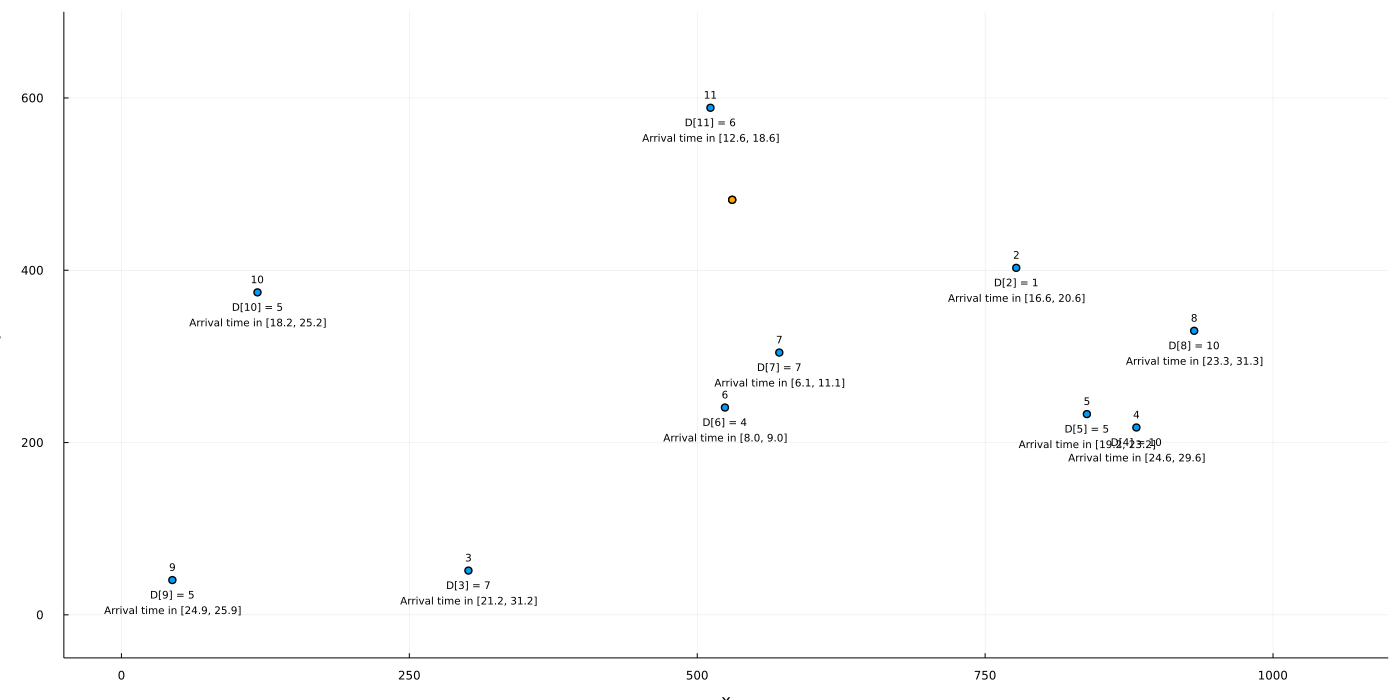

In [14]:
## Plotting nodes

scatter(test_ins.loc_x, test_ins.loc_y,
    legend = false,
    size = (1400,700),
    xaxis = ("x", (-50.0,1100.0)),
    yaxis = ("y", (-50.0,700.0)),
)

for i in test_ins.N
    annotate!(test_ins.loc_x[i], test_ins.loc_y[i] +15, ("$i", 7))
    
    annotate!(test_ins.loc_x[i], test_ins.loc_y[i] - 17, ("D[$(i)] = $(test_ins.D[i])", 7))
    annotate!(test_ins.loc_x[i], test_ins.loc_y[i] - 35, ("Arrival time in [$(round(test_ins.T_lb[i],digits=1)), $(round(test_ins.T_ub[i],digits=1))]", 7))
end

scatter!((test_ins.loc_x[1], test_ins.loc_y[1]), color=:orange)

### Item (a)
Write the MIP formulation in your report

### Item (b)
Complete the function `create_VRP_model()` below to implement the CVRPwTW model. The time windows and service times are only defined for client nodes. For the depot, the departure time should be nonnegative and there is no service time.

In [15]:
function create_VRP_model(ins; max_time = 300)
    
    n = ins.n          # Number of client nodes
    N = ins.N          # Set of client nodes
    V = ins.V          # Set of all nodes, including depot
    A = ins.A          # Set of arcs
    loc_x = ins.loc_x  # x-coordinates of all points
    loc_y = ins.loc_y  # y-coordinates of all points
    Q = ins.Q          # Vehicle capacity
    D = ins.D          # Demand at the node (to be delivered)
    #D[1]=0
    C = ins.C          # Arc traversal cost 
    S = ins.S          # Service time
    #S[1] = 0
    T = ins.T          # Travel time between
    T_lb = ins.T_lb    # Lower bound for the time window
    T_ub = ins.T_ub    # Upper bound for the time window
    bigM = ins.bigM    # A large enough big M value to be used in all big M constraints
    
    model = Model(Cbc.Optimizer)                # Declaring the model object.
    set_optimizer_attribute(model, "seconds", max_time)

    # Declare decision variables
    @variable(model, x[i in V, j in V], Bin) 
    @variable(model, 0 <= u[i in V] <= Q)
    @constraint(model, u[1]==Q)
    # TODO: add your code here
    @variable(model, a[i in V] >= 0)
    @constraint(model, a[1]==0)
    
    # Objective function
    @objective(model, Min, sum(C[i,j] * x[i,j] for (i,j) in A))

    # Constraints
    @constraint(model, c1[i in N], sum(x[i,j] for j in V if j != i) == 1)
    @constraint(model, [j in N], sum(x[i,j] for i in V if i != j) == 1)
    @constraint(model, [i in V, j in N], u[i] - D[j] <= u[j] + bigM * (1 - x[i,j]))
    @constraint(model, [i in V, j in N], u[i] - D[j] >= u[j] - bigM * (1 - x[i,j]))
    
    # TODO: add your code here
    @constraint(model, [i in N, j in N; i != j], a[j] >= a[i] + S[i] + T[i,j] - bigM * (1 - x[i,j]))
    @constraint(model, [j in N], a[j] >= a[1] + T[1,j] - bigM * (1 - x[1,j]))
    
    @constraint(model, [j in N], T_lb[j] <= a[j] <= T_ub[j])
    
    return model
end

create_VRP_model (generic function with 1 method)

In [16]:
## Create the basic model and optimise it
basic_model = create_VRP_model(test_ins; max_time = 300)
optimize!(basic_model)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -seconds 300 -solve -quit (default strategy 1)
seconds was changed from 1e+100 to 300
Continuous objective value is 1782.95 - 0.00 seconds
Cgl0003I 4 fixed, 0 tightened bounds, 48 strengthened rows, 1 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 43 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 32 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 13 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 55 rows, 33 columns (25 integer (25 of which binary)) and 286 elements
Cbc0038I Initial state - 8 integers unsatisfied sum - 0.00568297
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 5357.55 iterat

The cell below shows a plot of the solution. Use it to verify if your implementation is correct. Check, for example, that the arrival time is inside the allowed delivery time window.

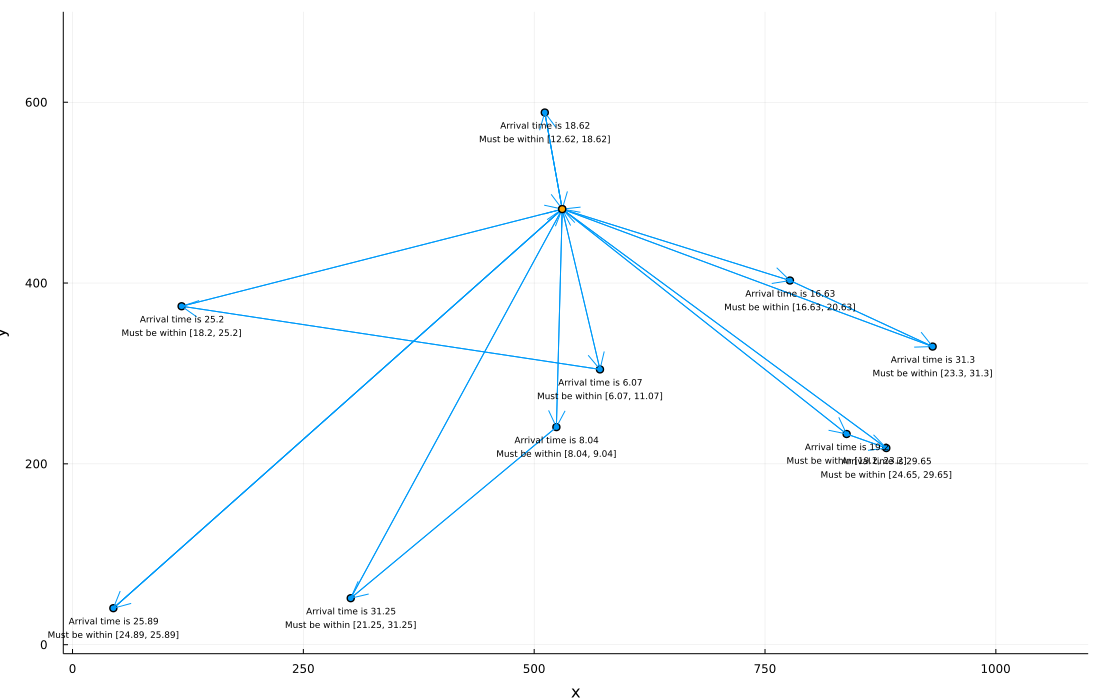

In [17]:
## Retrieving active arcs. 
active_arcs = [(i,j) for (i,j) in test_ins.A if value.(basic_model[:x])[i,j] >= 1-(1E-9)]

scatter(test_ins.loc_x, test_ins.loc_y,
    legend = false,
    size = (1100,700),
    xaxis = ("x", (-10.0,1100.0)),
    yaxis = ("y", (-10.0,700.0)),
)

for i in test_ins.N
    #annotate!(test_ins.loc_x[i], test_ins.loc_y[i] - 20, ("Arrival time is ???", :bottom, 6))
    annotate!(test_ins.loc_x[i], test_ins.loc_y[i] - 20, ("Arrival time is $(round(value.(basic_model[:a])[i], digits=2))", :bottom, 6))
    annotate!(test_ins.loc_x[i], test_ins.loc_y[i] - 35, ("Must be within [$(round(test_ins.T_lb[i],digits=2)), $(round(test_ins.T_ub[i],digits=2))]", :bottom, 6)) 
end

## Plotting the arcs
for (i,j) in active_arcs
    quiver!([test_ins.loc_x[i]], [test_ins.loc_y[i]], quiver=([test_ins.loc_x[j] - test_ins.loc_x[i]], [test_ins.loc_y[j] - test_ins.loc_y[i]]), 
        color = 1
    )
end

scatter!((test_ins.loc_x[1], test_ins.loc_y[1]), color=:orange)

#### Larger instance
After you're confident that your model works, use this bigger instance to solve the model with different solver configurations. These results are then what you should compare in your report.

In [18]:
f = jldopen("hw6_ins.jld2")
ins = nothing
try
    ins = f["ins"]
finally
    close(f)
end;

In [19]:
## Create the basic model and optimise it
basic_model = create_VRP_model(ins; max_time = 300)
optimize!(basic_model)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -seconds 300 -solve -quit (default strategy 1)
seconds was changed from 1e+100 to 300
Continuous objective value is 3894.8 - 0.02 seconds
Cgl0003I 7 fixed, 0 tightened bounds, 1906 strengthened rows, 3 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1788 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1871 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1839 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1803 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1754 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1701 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1646 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1576 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1516 strengthene

### Item (c)

Consider the configurations for parameters provided below and notice whether you can, comparing with the solution log from the previous item (i.e., with default parameter settings), choose a best one between the configurations. For parameter documentation, see https://www.gams.com/latest/docs/S_CBC.html

You can use as a reference for comparison, for example:
- Time taken to solve the problem or
- Optimality gap reached when the specified time limit was reached
- Number of nodes visited
- Solution at the root node before starting branching

In [20]:
# Configuration 1: turning off presolve.
no_presolve = create_VRP_model(ins; max_time = 300)

set_optimizer_attribute(no_presolve, "presolve", "off")

optimize!(no_presolve)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -presolve off -seconds 300 -solve -quit (default strategy 1)
Option for presolve changed from on to off
seconds was changed from 1e+100 to 300
Continuous objective value is 3894.8 - 0.02 seconds
Cgl0003I 7 fixed, 0 tightened bounds, 1906 strengthened rows, 3 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1781 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1868 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1832 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1797 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1747 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1702 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1642 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1559 strengthened rows, 0 substitutio

In [21]:
# Configuration 2: turning off cuts.
no_cuts = create_VRP_model(ins; max_time = 300)

set_optimizer_attribute(no_cuts, "cuts", "off")

optimize!(no_cuts)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -seconds 300 -cuts off -solve -quit (default strategy 1)
seconds was changed from 1e+100 to 300
Option for cutsOnOff changed from on to off
Continuous objective value is 3894.8 - 0.03 seconds
Cgl0003I 7 fixed, 0 tightened bounds, 1906 strengthened rows, 3 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1788 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1871 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1839 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1803 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1754 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1701 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1646 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1576 strengthened rows, 0 substitutions


In [22]:
# Configuration 3: turning off heuristics.
no_heuristics = create_VRP_model(ins; max_time = 300)

set_optimizer_attribute(no_heuristics, "heuristics", "off")

optimize!(no_heuristics)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -heuristics off -seconds 300 -solve -quit (default strategy 1)
Option for heuristicsOnOff changed from on to off
seconds was changed from 1e+100 to 300
Continuous objective value is 3894.8 - 0.03 seconds
Cgl0003I 7 fixed, 0 tightened bounds, 1906 strengthened rows, 3 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1788 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1871 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1839 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1803 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1754 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1701 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1646 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1576 strengthened rows, 0 su

In [23]:
# Configuration 4: using a lot of cuts and heuristics.
model_mod = create_VRP_model(ins; max_time = 300)

set_optimizer_attributes(model_mod, 
    "cliqueCuts" => "on",
    "GMICuts" => "on",
    "reduceAndSplitCuts" => "on",
    "knapsackCuts" => "on",
    "flowCoverCuts" => "on",
    "liftAndProjectCuts" => "on",
    "zeroHalfCuts" => "on",
    "cutDepth" => 500
)

set_optimizer_attributes(model_mod, 
    "Rins" => "on",
    "Rens" => "on",
    "VndVariableNeighborhoodSearch" => "on",
    "DivingSome" => "on",
    "expensiveStrong" => 2
)

optimize!(model_mod)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -Rens on -reduceAndSplitCuts on -liftAndProjectCuts on -flowCoverCuts on -knapsackCuts on -zeroHalfCuts on -GMICuts on -Rins on -seconds 300 -VndVariableNeighborhoodSearch on -cutDepth 500 -expensiveStrong 2 -cliqueCuts on -DivingSome on -solve -quit (default strategy 1)
Option for Rens changed from off to on
Option for reduceAndSplitCuts changed from off to on
Option for liftAndProjectCuts changed from off to on
Option for flowCoverCuts changed from ifmove to on
Option for knapsackCuts changed from ifmove to on
Option for zeroHalfCuts changed from ifmove to on
Option for GMICuts changed from off to on
seconds was changed from 1e+100 to 300
Option for VndVariableNeighborhoodSearch changed from off to on
cutDepth was changed from -1 to 500
expensiveStrong was changed from 0 to 2
Option for cliqueCuts changed from ifmove to on
Option for DivingSome changed from off to on
Continuous o